In [3]:
import soundfile
import os
import librosa
import pyaudio
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import re

# I. Feature extraction, standarization and feature importance evaluation

In [4]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

Read four datasets and prepare for the extraction

In [5]:
emotions_ravdess={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
emotions_TESS={
    'fear':'fearful',
    'sad':'sad',
    'angry':'angry',
    'disgust':'disgust',
    'happy':'happy',
    'neutral':'neutral',
    'ps':'surprised'
}
emotions_SAVEE={
    'f':'fearful',
    'sa':'sad',
    'a':'angry',
    'd':'disgust',
    'h':'happy',
    'n':'neutral',
    'su':'surprised'
}
emotions_CREMA_D={
    'FEA':'fearful',
    'SAD':'sad',
    'ANG':'angry',
    'DIS':'disgust',
    'HAP':'happy',
    'NEU':'neutral'
}
#DataFlair - Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust','neutral','sad','angry','surprised']

Load the data, extract features for each sound file and split the dataset

In [6]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    #RAVDESS
    for file in glob.glob("RAVDESS\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_ravdess[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    #TESS
    for file in glob.glob("TESS\\*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_TESS[re.split(r'[_.\s]\s*',file_name)[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    #SAVEE ######
    for file in glob.glob("SAVEE\\*\\*.wav"):
        file_name=os.path.basename(file)
        if file_name[1].isdigit():
            emoss=file_name[0]
        else:
            emoss=file_name[:2]
        emotion=emotions_SAVEE[emoss]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion) 
    #CREMA-D
    for file in glob.glob("CREMA-D\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_CREMA_D[file_name.split("_")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)     
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [7]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.1)

D:\Anacoda\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Show the shape of our data

In [8]:
#DataFlair - Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(10945, 1217)


In [9]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


Standarization part, in order to imporve accuracy

In [10]:
#standarization
from sklearn.preprocessing import StandardScaler
x_total=np.vstack([x_train,x_test])
transformer = StandardScaler().fit(x_total)
x_tr_s = transformer.transform(x_train)
x_te_s = transformer.transform(x_test)
x_tl_s = transformer.transform(x_total)

Feature importance evaluation

In [11]:
#evaluate the importance of features
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [12]:
xtes_df=pd.DataFrame(x_te_s)
xtrs_df=pd.DataFrame(x_tr_s)
xtls_df=pd.DataFrame(x_tl_s)
yte_df=pd.DataFrame(y_test)
ytr_df=pd.DataFrame(y_train)
y=pd.DataFrame(y_train+y_test)

In [13]:
#using random forest
feat_labels=xtls_df.columns
forest=RandomForestClassifier(n_jobs=-1)
forest.fit(xtls_df,y)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]

for i in range(len(indices)):
    print("%2d. %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

<ipython-input-13-228a97949c44>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(xtls_df,y)


 1. 136                            0.011180
 2. 137                            0.010229
 3. 37                             0.010149
 4. 58                             0.010068
 5. 62                             0.009692
 6. 135                            0.009361
 7. 0                              0.009307
 8. 20                             0.009075
 9. 61                             0.008941
10. 17                             0.008926
11. 145                            0.008898
12. 134                            0.008593
13. 56                             0.008494
14. 36                             0.008331
15. 35                             0.008287
16. 63                             0.008089
17. 138                            0.007940
18. 57                             0.007875
19. 50                             0.007727
20. 49                             0.007673
21. 38                             0.007660
22. 22                             0.007627
23. 59                          

# II. Modeling (MLP, Decision tree, Extra tree, SVM, Random forest)

1. MLP and its confusion matrix 

In [14]:
#MLP
mlp=MLPClassifier(solver='adam',activation='logistic',hidden_layer_sizes=[100],random_state=1,learning_rate='adaptive',alpha=0.1,max_iter=1000).fit(x_tr_s,y_train)
y_pred=mlp.predict(x_te_s)
mlp_acc=accuracy_score(y_true=y_test, y_pred=y_pred)
print(mlp_acc)

0.6351684470008216


In [15]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
cm = confusion_matrix(y_test, y_pred,labels=['calm', 'happy', 'fearful', 'disgust','neutral','sad','angry','surprised'])
cm

array([[ 12,   0,   0,   1,   0,   1,   0,   0],
       [  0, 124,  17,  24,  11,   7,  19,   0],
       [  0,  17, 101,  16,   5,  29,  11,   1],
       [  2,  25,  11, 112,  25,  17,  11,   4],
       [  2,  13,   8,  20, 104,  18,   1,   2],
       [  5,   2,  19,  18,  19, 124,   1,   0],
       [  0,  18,   7,  23,   2,   1, 142,   3],
       [  0,   1,   3,   4,   0,   0,   0,  54]], dtype=int64)

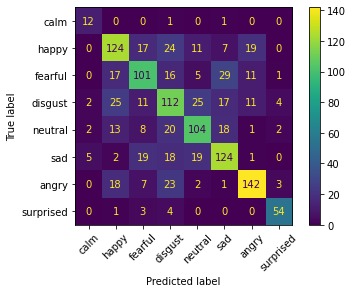

In [22]:
labels=['calm', 'happy', 'fearful', 'disgust','neutral','sad','angry','surprised']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

2. Decision Tree

In [26]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier

In [52]:
tree = DecisionTreeClassifier(random_state=5, criterion='gini', max_depth=16).fit(x_tr_s, y_train)
y_pred= tree.predict(x_te_s)
DT_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(DT_acc)

0.5135579293344289


3. Extra tree and its confusion matrix

In [23]:
#Extratree
from sklearn.ensemble import ExtraTreesClassifier

In [24]:
etree = ExtraTreesClassifier(n_estimators=150, max_depth=41,min_samples_split=2,n_jobs=-1,random_state=0).fit(x_tr_s, y_train)
y_pred= etree.predict(x_te_s)
ET_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(ET_acc)

0.637633525061627


In [25]:
cm = confusion_matrix(y_test, y_pred,labels=['calm', 'happy', 'fearful', 'disgust','neutral','sad','angry','surprised'])
cm

array([[ 13,   0,   0,   0,   0,   1,   0,   0],
       [  2, 121,   7,  17,  19,   7,  28,   1],
       [  0,  26,  71,  14,  17,  31,  21,   0],
       [  2,  31,   8,  98,  27,  27,  12,   2],
       [  4,   8,   2,  14, 121,  16,   2,   1],
       [  5,   2,   7,   7,  23, 144,   0,   0],
       [  1,  22,   3,  12,   2,   0, 153,   3],
       [  0,   2,   1,   3,   0,   1,   0,  55]], dtype=int64)

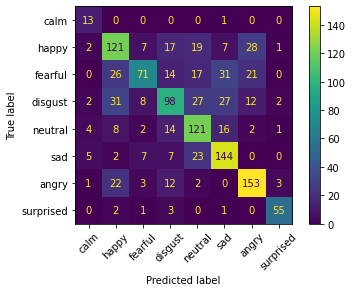

In [27]:
labels=['calm', 'happy', 'fearful', 'disgust','neutral','sad','angry','surprised']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation=45)
plt.show()

4.Support vector machine

In [30]:
#SVM
from sklearn import svm
svmmodel = svm.SVC(kernel='rbf', gamma='auto') .fit(x_tr_s, y_train)
y_pred=svmmodel.predict(x_te_s)
svm_acc=accuracy_score(y_true=y_test, y_pred=y_pred)
print(svm_acc)

0.5875102711585867


5. Random Forest

In [70]:
#RF
from sklearn.ensemble import RandomForestClassifier

In [78]:
rfc = RandomForestClassifier(n_estimators=110,max_depth=20,n_jobs=-1,min_samples_leaf=2,min_samples_split=14,random_state=0).fit(x_tr_s, y_train)
y_pred= rfc.predict(x_te_s)
rf_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print(rf_acc)

0.6162695152013147
